## GH Decomposition of XFEL Data

In [3]:
import h5py 
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
import os
import tqdm
import math
from scipy.interpolate import RectBivariateSpline
import copy
import shutil

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate 
import scipy.interpolate as interpolate
from math import pi
from math import factorial
from scipy.integrate import simps

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd

2022-10-31 12:59:34.635341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 12:59:34.635429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Extract data from runs 62 and 63

grid_dim = 64

runids = [62,65]
fi_lst = []
E_lst = np.zeros((1,grid_dim,grid_dim))
Ib_lst = np.zeros((1,grid_dim,grid_dim))
I0_lst = np.zeros(1)
for runid in runids:
    fi = h5py.File('Run'+str(runid)+'.h5','r')
    E = fi['recoveredBeam'][()]
    Ib=np.abs(E)**2
    I0=fi['I0'][()]
    fi_lst.append(fi)
    E_lst = np.concatenate((E_lst,E))
    Ib_lst = np.concatenate((Ib_lst,Ib))
    I0_lst = np.concatenate((I0_lst,I0))

I0_lst = I0_lst[1:]
E_lst = E_lst[1:]
Ib_lst = Ib_lst[1:]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Run62.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

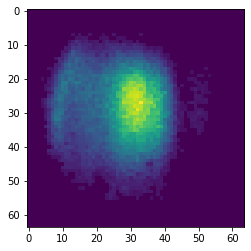

In [13]:
plt.imshow(Ib_lst[70])

In [3]:
# Set data to nan which needs to be filtered, i.e. data under physical threshold,  and normalize viable samples

for i,image in enumerate(Ib_lst):
    if np.sum(image.astype(int) != 0) < 10:
        Ib_lst[i] = np.nan*np.ones((64,64))
        E_lst[i] = np.nan*np.ones((64,64))
        I0_lst[i] = np.nan
    if 0 != np.sum(image):
        Ib_lst[i] = image/np.sum(image)
        E_lst[i] = E_lst[i]/np.sum(np.abs(E_lst[i]))

In [141]:
# Batch process for low computational load

E_sample = E_lst[np.random.shuffle(np.arange(E_lst.shape[0]))][:100,:,:][0][0]
E_phase_sample = np.angle(E_lst[np.random.shuffle(np.arange(E_lst.shape[0]))][:100,:,:][0][0])

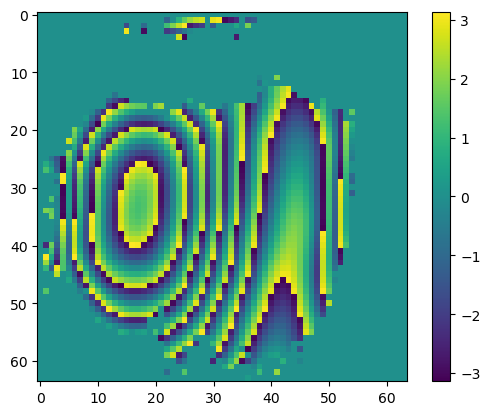

In [135]:
plt.imshow(E_phase_sample)
plt.colorbar()

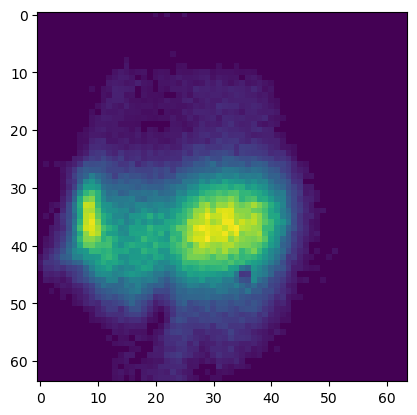

In [148]:
plt.imshow(Ib_lst[0])

In [4]:
# Creating new X data
delay_ns_lst=np.zeros(1)
BC2_lst = np.zeros(1)
L3E_lst = np.zeros(1)
gdet1_lst = np.zeros(1)
ipm2_lst = np.zeros(1)
p0x = np.zeros(1)
p0y = np.zeros(1)
peak = np.zeros(1)
area = np.zeros(1)

for fi in fi_lst:
    delay_ns_lst = np.concatenate((delay_ns_lst,fi['2bunch_delay_ns'][()]))
    BC2_lst = np.concatenate((BC2_lst,fi['BC2'][()]))
    L3E_lst = np.concatenate((L3E_lst,fi['L3E'][()]))
    gdet1_lst = np.concatenate((gdet1_lst,fi['gdet1'][()]))
    ipm2_lst = np.concatenate((ipm2_lst,fi['ipm2'][()]))
    p0x = np.concatenate((p0x,fi['p0x'][()]))
    p0y = np.concatenate((p0y,fi['p0y'][()]))
    gdet_wf = fi['gdet_wf'][()]
    peak = np.concatenate((peak,np.min(gdet_wf,axis=1)))
    area = np.concatenate((area,np.trapz(gdet_wf,axis=1)))
    

df_dict = {
'2bunch_delay_ns': delay_ns_lst[1:],
'I0': np.array(I0_lst),
'BC2': BC2_lst[1:],
'L3E': L3E_lst[1:],
'gdet1': gdet1_lst[1:],
'ipm2': ipm2_lst[1:],
'p0x': p0x[1:],
'p0y': p0y[1:],
'peak':peak[1:],
'area':area[1:]
}

X_df = pd.DataFrame(df_dict)


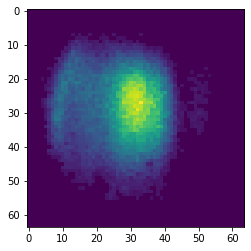

In [15]:
plt.imshow(Ib_lst[70])

In [13]:
np.sum(Ib_lst[110][25:45,5:15]), np.sum(Ib_lst[70][25:45,5:15])

(0.2349811330970974, 0.07754705574577976)

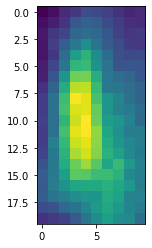

In [11]:
plt.imshow(Ib_lst[110][25:45,5:15])

In [5]:
X_df

,2bunch_delay_ns,I0,BC2,L3E,gdet1,ipm2,p0x,p0y,peak,area
0,49.0,4.259890e+06,3524.021484,12205.782105,0.541786,445.875,3.667680e+08,2.536378e+08,-0.335547,-39.177393
1,49.0,2.248081e+06,3651.088623,12209.326193,0.627729,88.500,1.201291e+08,2.455860e+08,-0.379004,-42.527246
2,49.0,1.408874e+07,3499.982422,12203.732977,0.553726,179.250,6.552396e+08,2.704881e+08,-0.379004,-40.257471
3,49.0,4.690690e+06,3579.837402,12211.119006,0.536263,177.750,3.273213e+08,2.489175e+08,-0.333594,-39.092188
4,49.0,2.097581e+06,3608.941895,12204.955629,0.491913,101.375,2.605051e+08,2.473373e+08,-0.311621,-37.516992
...,...,...,...,...,...,...,...,...,...,...
39465,52.5,2.311819e+07,12250.569336,12198.480518,0.734217,795.875,3.744340e+08,2.679726e+08,-0.455176,-46.372949
39466,52.5,1.667841e+06,10712.398438,12204.623393,0.590067,113.625,6.263707e+08,2.903290e+08,-0.397559,-41.333398
39467,52.5,5.925388e+05,12524.323242,12204.848346,0.670850,53.375,8.270241e+08,2.798962e+08,-0.387793,-43.719385
39468,52.5,2.677876e+06,10083.450195,12208.384669,0.516706,128.875,6.178186e+08,2.703240e+08,-0.284766,-37.795313


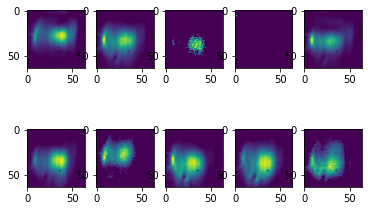

In [10]:
# Show leftward peak samples prominence in data
indices = []
for i in range(10):
    plt.subplot(2,5,1+i)
    indices.append(int(np.random.uniform(0,2000)))
    plt.imshow(Ib_lst[indices[-1]])

In [5]:
# Drop values which have the explicit leftward peak as seen in the previous cell
for i in range(X_df.values.shape[0]):
    if np.sum(Ib_lst[i][25:45,5:15]) > .1:
        X_df = X_df.drop(i)
X_df.values.shape

(29907, 10)

1312 2996
0 4284
1635 2793
446 4086
1369 2150
738 1758
1347 2585
1188 2944
883 3782
127 3719


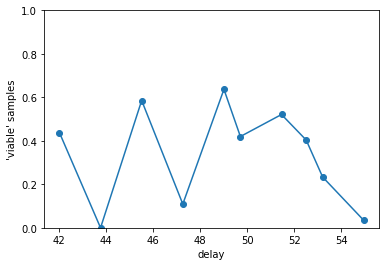

In [15]:
percent_na = []
for df in df_subset_lst:
    max_pixels = np.max(np.max(Ib_lst[df.index,:,:],axis = 1), axis=1)
    print(sum(max_pixels > 400),len(df.index))
    percent_na.append(sum(max_pixels > 400)/len(df.index))
plt.plot(delays,percent_na, 'o-')
plt.ylim(0,1)
plt.xlabel("delay")
plt.ylabel("'viable' samples");

In [6]:

# Experimental parameters
wavelen = 1.3e-10
window_extent = 3e-4
w_0 = 5e-5
pixel_dim = grid_dim
pixel_metric = window_extent/pixel_dim

# Function to build the container of coefficients.  Returns n x m array of coefficients with the n,m entry being the n,m mode
def gauss_hermite_decomp(E, z, w_0=w_0):
    coeffs = np.array([get_coeff(n, m, E, z, w_0) for n in range(N) for m in range(M)])
    return coeffs.reshape((M,N))

# Getter for the actual integration involved with a particular n,m mode
def get_coeff(n, m, E, z, w_0):
    z_R = pi*w_0**2/wavelen
    w = w_0*(1 + (z/z_R)**2)**0.5
    hermite_indices_n = np.zeros(N)
    hermite_indices_m = np.zeros(M)
    hermite_indices_n[n] = 1
    hermite_indices_m[m] = 1
    herm_ply_n = np.polynomial.Hermite(hermite_indices_n, [-window_extent*np.sqrt(2)/w/2, window_extent*np.sqrt(2)/w/2], [-window_extent*np.sqrt(2)/w/2, window_extent*np.sqrt(2)/w/2])
    herm_ply_n_eval = herm_ply_n.linspace(n=pixel_dim)
    herm_ply_m = np.polynomial.Hermite(hermite_indices_m, [-window_extent*np.sqrt(2)/w/2, window_extent*np.sqrt(2)/w/2], [-window_extent*np.sqrt(2)/w/2, window_extent*np.sqrt(2)/w/2])
    herm_ply_m_eval = herm_ply_m.linspace(n=pixel_dim)
    x = np.linspace(-window_extent/2,window_extent/2,pixel_dim)
    mesh_xy = np.meshgrid(x,x)
    coeff = simps(simps(integrand_x(mesh_xy[0],mesh_xy[1],z,z_R,w,w_0,E,herm_ply_n_eval,herm_ply_m_eval,n,m),x),x)
    return coeff
    
# Fucntion to build the integrand which will yield the coefficient for a given n,m
def integrand_x(x,y,z,z_R,w,w_0,E,herm_ply_n_eval,herm_ply_m_eval,n,m):
    #E_0 = np.max(np.abs(E))
    k = 2*pi/wavelen
    R = z*(1 + (z_R/z)**2)
    psi = np.arctan(pi*w**2/(z*wavelen))
    psi_0 = np.arctan(pi*w_0**2/z*wavelen)
    u_n_star_no_hermite = (2/pi)**0.25  * np.sqrt(np.exp(1j*(2*n+1)*(psi - psi_0))/(2**n * factorial(n) * w)) *  np.exp(1j*(k*x**2)/(2*R) - x**2/(w**2))
    u_m_star_no_hermite = (2/pi)**0.25  * np.sqrt(np.exp(1j*(2*m+1)*(psi - psi_0))/(2**m * factorial(m) * w)) *  np.exp(1j*(k*y**2)/(2*R) - y**2/(w**2))
    hermites = herm_ply_n_eval[1].reshape(pixel_dim,1) @ herm_ply_m_eval[1].reshape(1,pixel_dim)
    return u_n_star_no_hermite*u_m_star_no_hermite*hermites*E

In [9]:
X_df.values.shape

(29907, 10)

In [7]:
np.sum(np.isnan(X_df.values))

17927

In [7]:
X_df = X_df.dropna('index')
X_df.shape

/tmp/ipykernel_58463/451923324.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  X_df = X_df.dropna('index')


(11980, 10)

In [8]:
# Group data according to 2 bunhc delay as the supposed relevant dynamical parameter
delay_grps = X_df.groupby('2bunch_delay_ns')
delays = []
df_subset_lst = []
for name, group in delay_grps:
    delays.append(name)
    df_subset_lst.append(group)

In [9]:
import time

In [22]:
# Apply GH mode transformation to data which not noise according to delay group

start = time.time()
# First 49 modes up to GH_{7,7}
M = 7
N = 7
X_clean_total = np.zeros(df_subset_lst[0].values.shape[1])
y_clean_total = np.zeros(M*N)

for df in df_subset_lst:
    # Remove data beneath the background signal threshold
    max_pixels = np.max(np.max(Ib_lst[df.index,:,:],axis = 1), axis=1)
    mask_noise = max_pixels > 200
    print(sum(mask_noise))
    X_clean_total = np.vstack((X_clean_total,df.values[mask_noise]))
    for E in E_lst[df.index][mask_noise]:
        # For actual analysis
        #y_clean_total = np.vstack((y_clean_total,np.abs(gauss_hermite_decomp(E,150).flatten())))
        # For checking phase dist.
        y_clean_total = np.vstack((y_clean_total,gauss_hermite_decomp(E,150).flatten()))
        
X_clean_total = X_clean_total[1:,:]
y_clean_total = y_clean_total[1:,:]
end = time.time()
(end - start)/60

0
0
0
0
0
0
0
0
0
0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Text(0.5, 1.0, 'Phase < $10^{-3}$ per Mode')

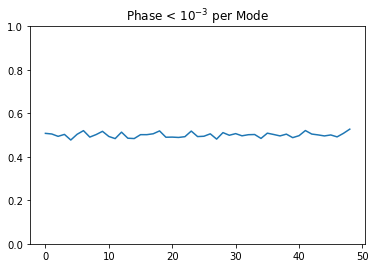

In [18]:
plt.plot(np.sum(np.angle(y_clean_total) < 1e-3, axis=0)/y_clean_total.shape[0])
plt.ylim(0,1)
plt.title("Phase < $10^{-3}$ per Mode")

In [25]:
start = time.time()
M = 7
N = 7
X_clean_total = np.zeros(df_subset_lst[0].values.shape[1])
y_clean_total = np.zeros(M*N)

for df in df_subset_lst:
    max_pixels = np.max(np.max(Ib_lst[df.index,:,:],axis = 1), axis=1)
    mask_noise = max_pixels > 600
    print(sum(mask_noise))
    X_clean_total = np.vstack((X_clean_total,df.values[mask_noise]))
    for E in E_lst[df.index][mask_noise]:
        # For actual analysis, it could be more correct to use absolute value
        #y_clean_total = np.vstack((y_clean_total,np.abs(gauss_hermite_decomp(E,150).flatten())))
        
        # If we want to check phase though
        y_clean_total = np.vstack((y_clean_total,gauss_hermite_decomp(E,150).flatten()))
        
X_clean_total = X_clean_total[1:,:]
y_clean_total = y_clean_total[1:,:]
end = time.time()
(end - start)/60

1411
0
1435
294
4556
2823
2452
1626
615
253


7.728525706132253

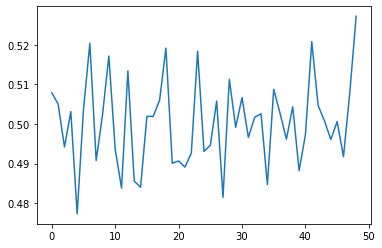

In [19]:
# The idea is the modes should all have roughly the same phase and it should be near 0
plt.plot(np.sum(np.angle(y_clean_total) < 1e-3, axis=0)/y_clean_total.shape[0])

In [36]:
np.max(np.abs(y_clean_total),axis=0)

array([0.00167747, 0.00190144, 0.00048487, 0.00142556, 0.00109563,
       0.00082214, 0.00118408, 0.0012609 , 0.00091715, 0.00040905,
       0.0006752 , 0.00058671, 0.00037783, 0.00072182, 0.00083121,
       0.00095933, 0.00030583, 0.00072925, 0.00051716, 0.00049408,
       0.00059222, 0.00081616, 0.00060165, 0.00017069, 0.00046112,
       0.00033708, 0.00031024, 0.0004331 , 0.00072282, 0.00086059,
       0.00027266, 0.00067033, 0.00039663, 0.00043176, 0.00045303,
       0.00058871, 0.00052147, 0.00016711, 0.0003937 , 0.00032825,
       0.00026484, 0.00033805, 0.00063571, 0.00075896, 0.00017681,
       0.00056426, 0.00032204, 0.00033454, 0.00039481])

In [11]:
# Transform to our new set
largest_vec = np.max(np.abs(y_clean_total)**2,axis=0)
y_newVars = np.abs(y_clean_total)**2/np.linalg.norm(largest_vec)
X_newVars = X_clean_total

In [36]:
delays

[42.0,
 43.75,
 45.5,
 47.25,
 49.0,
 49.699999999999996,
 51.449999999999996,
 52.5,
 53.199999999999996,
 54.949999999999996]

0 877
877 3264
3264 4143
4143 5725
5725 6388
6388 8744
8744 9970
9970 11804
11804 11980


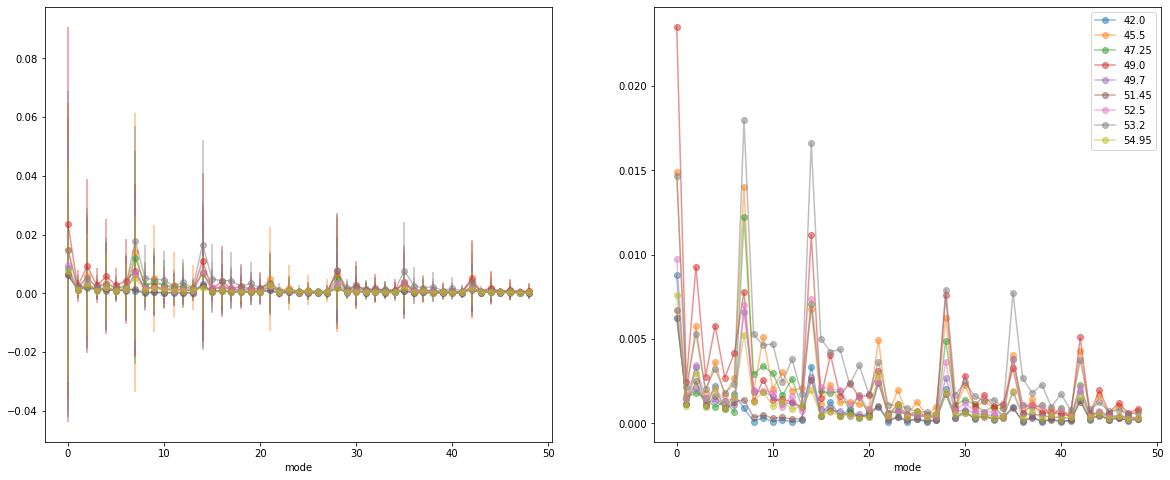

In [12]:
# Let's look at the modes' amplitude over the specific subsets with and without error bars
plt.figure(figsize=(20,8))
begin = 0
end = 0
for df in df_subset_lst:
    plt.subplot(1,2,1)
    plt.xlabel('mode')
    end += df.values.shape[0]
    print(begin,end)
    plt.errorbar(np.arange(M*N),np.average(y_newVars[begin:end], axis=0), yerr=np.std(y_newVars[begin:end], axis=0), alpha = 0.5, marker='o')
    plt.subplot(1,2,2)
    plt.xlabel('mode')
    plt.plot(np.average(y_newVars[begin:end], axis=0), alpha = 0.5, marker='o')
    begin = end 
plt.legend([str(round(delay,2)) for delay in delays])

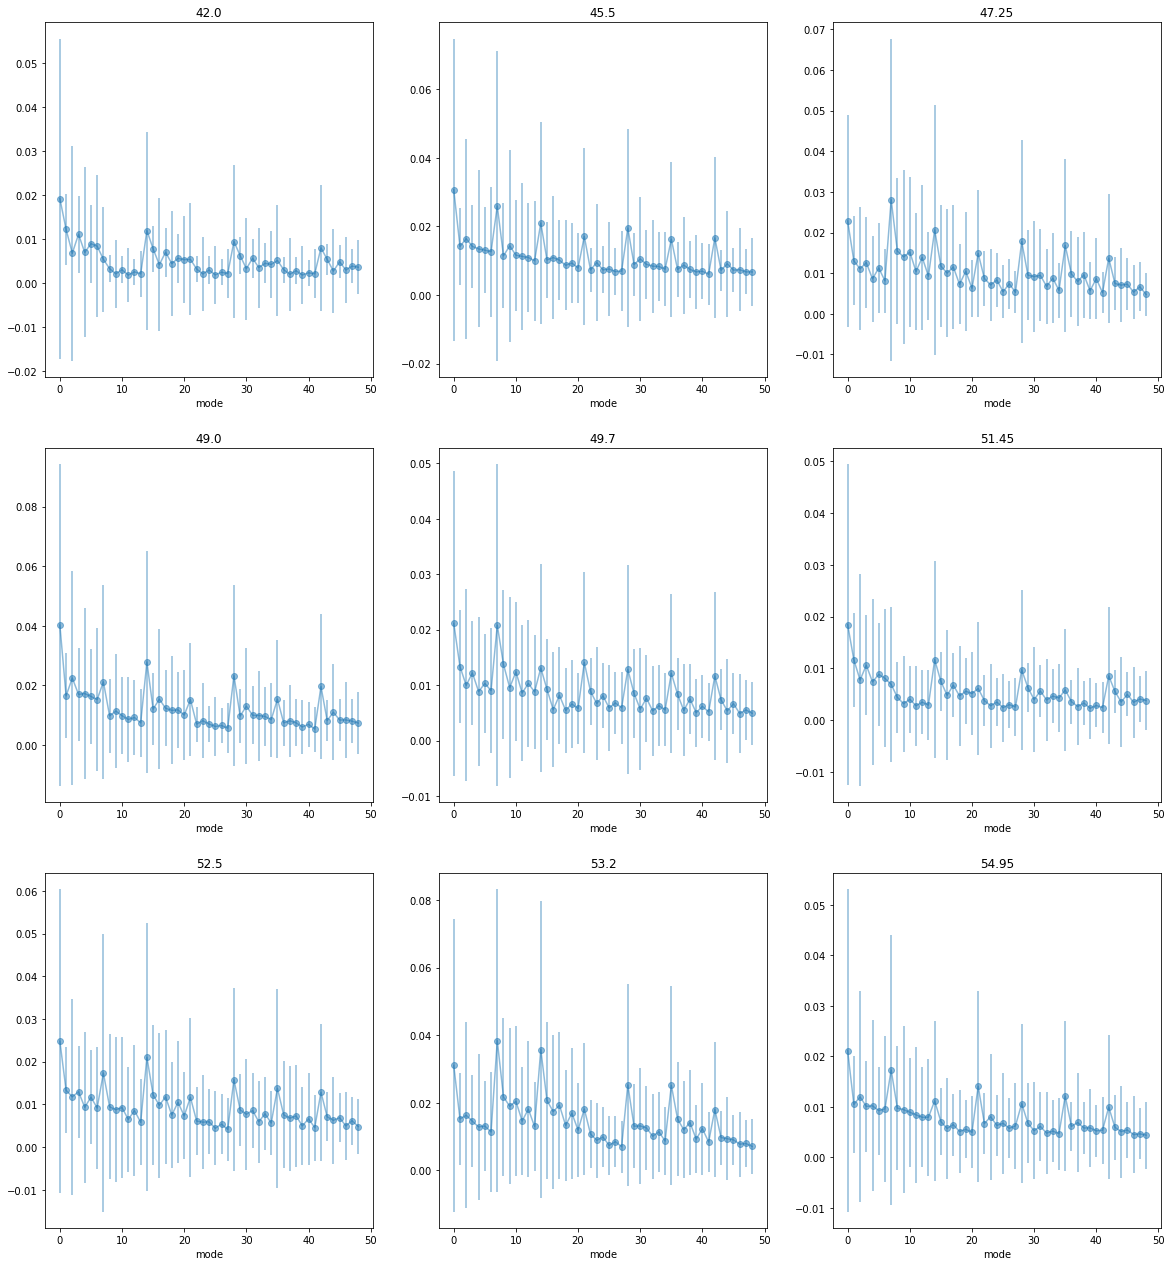

In [31]:
# For the individual plots
begin = 0
end = 0
plt.figure(figsize=(20,30))
for i,df in enumerate(df_subset_lst):
    #max_pixels = np.max(np.max(Ib_lst[df.index,:,:],axis = 1), axis=1)
    end += df.values.shape[0]
    plt.subplot(4,3,i+1)
    plt.title(str(round(delays[i],2)))
    plt.xlabel('mode')
    plt.errorbar(np.arange(M*N),np.average(y_newVars[begin:end], axis=0), yerr=np.std(y_newVars[begin:end], axis=0), alpha = 0.5, marker='o')
    begin=end

In [48]:
# Building the correlation matrix for data inputs and mode amplitude
corrMat_norm_allData = np.zeros((len(X_newVars[0]), len(y_newVars[0])))
for i in range(len(X_newVars[0])):
    for j in range(len(y_newVars[0])):
        X = X_newVars[:, i]
        y = y_newVars[:, j]
        
        normedX = (X - np.mean(X)) / np.std(X)
        normedY = (y - np.mean(y)) / np.std(y)
        
        
        val = normedX @ normedY
        norms = np.linalg.norm(normedX) * np.linalg.norm(normedY)
        val /= norms
        corrMat_norm_allData[i][j] = val

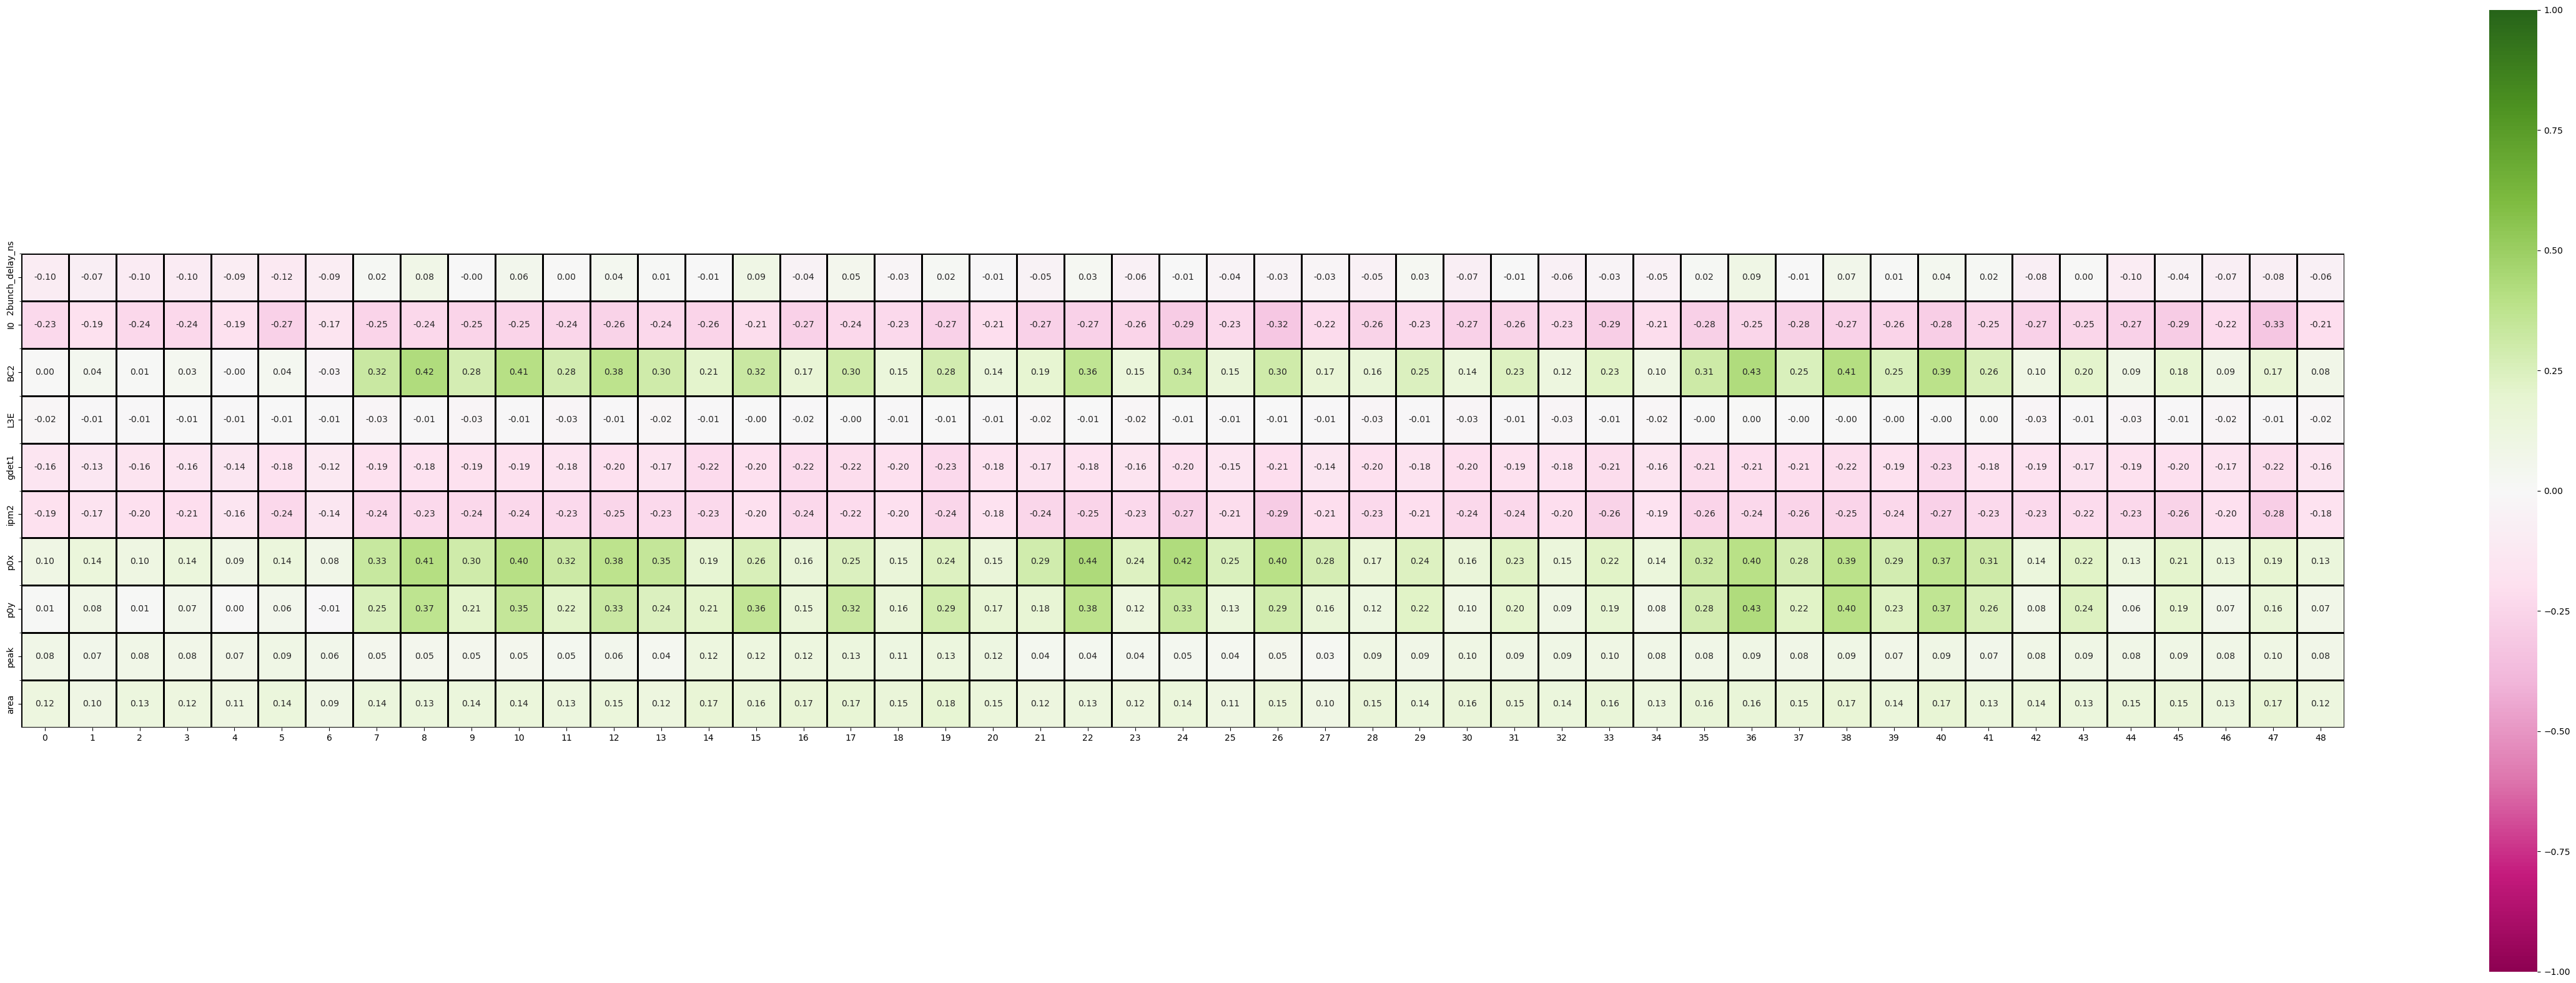

In [49]:
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)
f = plt.figure()
f.set_figwidth(60)
f.set_figheight(20)
ax = sns.heatmap(corrMat_norm_allData, cmap="PiYG", vmin = -1, vmax = 1, linewidths=1, linecolor='black', annot=True, fmt = '.2f', square=1)
ax.set_yticks(range(0, 10), minor=True)
ax.set_yticklabels(df_subset_lst[0].columns)
plt.show()

In [71]:
# Train/Validate split -- yes I know the variable is named by test
X_train_nozeros, X_test_nozeros, y_train_nozeros, y_test_nozeros = train_test_split(X_newVars, y_newVars, test_size=0.33)

In [72]:
# Train model according to a vanilla network architecture 128, 128 with relu activation

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(M*N))


model.compile(optimizer = 'adam', 
              loss = 'mean_squared_error',
              metrics = ['mean_absolute_error'])

# Normalize data
X_mean = np.mean(X_train_nozeros,axis=0)
X_std = np.std(X_train_nozeros, axis=0)
X_train_nozeros = (X_train_nozeros - X_mean)/X_std
y_mean = np.mean(y_train_nozeros, axis=0)
y_std = np.std(y_train_nozeros, axis=0)
#y_train_nozeros = (y_train_nozeros - np.mean(y_train_nozeros, axis=0))/np.std(y_train_nozeros, axis=0)
X_test_nozeros = (X_test_nozeros - np.mean(X_test_nozeros, axis=0))/np.std(X_test_nozeros, axis=0)
#y_test_nozeros = (y_test_nozeros - np.mean(y_test_nozeros, axis=0))/np.std(y_test_nozeros, axis=0)

model.fit(X_train_nozeros, (y_train_nozeros-y_mean)/y_std, epochs = 10)

Epoch 1/10
251/251 [==============================] - 0s 719us/step - loss: 0.8234 - mean_absolute_error: 0.5283
Epoch 2/10
251/251 [==============================] - 0s 734us/step - loss: 0.6861 - mean_absolute_error: 0.4724
Epoch 3/10
251/251 [==============================] - 0s 796us/step - loss: 0.6188 - mean_absolute_error: 0.4453
Epoch 4/10
251/251 [==============================] - 0s 736us/step - loss: 0.5692 - mean_absolute_error: 0.4257
Epoch 5/10
251/251 [==============================] - 0s 774us/step - loss: 0.5446 - mean_absolute_error: 0.4137
Epoch 6/10
251/251 [==============================] - 0s 759us/step - loss: 0.5110 - mean_absolute_error: 0.4031
Epoch 7/10
251/251 [==============================] - 0s 848us/step - loss: 0.4914 - mean_absolute_error: 0.3939
Epoch 8/10
251/251 [==============================] - 0s 784us/step - loss: 0.4835 - mean_absolute_error: 0.3899
Epoch 9/10
251/251 [==============================] - 0s 738us/step - loss: 0.4844 - mean_absolu

In [73]:
predictions_MLP_nozeros = model.predict([X_test_nozeros])*y_std + y_mean

In [74]:
# Consolidate error at validation stage
test_mae = np.average(((predictions_MLP_nozeros-y_mean)/y_std - y_test_nozeros)**2, axis=0)
mode_text_vec = []

for i in range(M):
    for j in range(N):
        mode_label = 'E_' + str(i) + "_" + str(j)
        mode_text_vec.append(mode_label)
        
pd.DataFrame({'mode': mode_text_vec, 'test_mae': test_mae})

,mode,test_mae
0,E_0_0,0.375629
1,E_0_1,0.318479
2,E_0_2,0.395371
3,E_0_3,0.370050
4,E_0_4,0.361426
5,E_0_5,0.417613
6,E_0_6,0.339257
7,E_1_0,0.477887
8,E_1_1,0.520160
9,E_1_2,0.473017


In [104]:
# Which modes perform best
np.array(mode_text_vec)[test_mae < 0.6]

array(['E_0_0', 'E_0_1', 'E_0_2', 'E_0_3', 'E_0_4', 'E_0_5', 'E_0_6',
       'E_1_0', 'E_1_1', 'E_1_2', 'E_1_3', 'E_1_4', 'E_1_5', 'E_1_6',
       'E_2_0', 'E_2_1', 'E_2_2', 'E_2_3', 'E_2_4', 'E_2_5', 'E_2_6',
       'E_3_0', 'E_3_1', 'E_3_2', 'E_3_3', 'E_3_4', 'E_3_5', 'E_3_6',
       'E_4_0', 'E_4_1', 'E_4_2', 'E_4_3', 'E_4_4', 'E_4_5', 'E_4_6',
       'E_5_0', 'E_5_1', 'E_5_2', 'E_5_3', 'E_5_4', 'E_5_5', 'E_5_6',
       'E_6_0', 'E_6_1', 'E_6_2', 'E_6_3', 'E_6_4', 'E_6_5', 'E_6_6'],
      dtype='<U5')

Text(0.5, 0, 'I0')

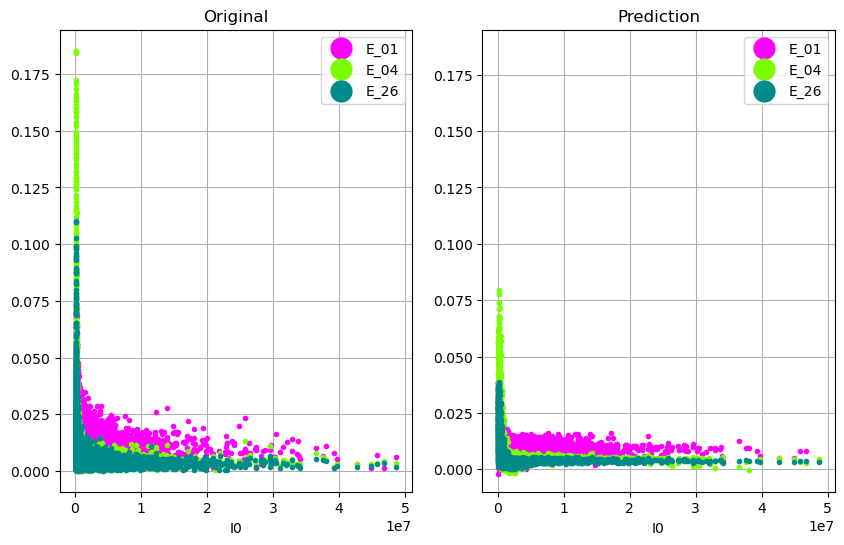

In [112]:
# Consolidate distributions from original and model for peak intensity
test_var = X_test_nozeros[:, 1]*X_std[1]+X_mean[1]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(test_var, y_test_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(test_var, y_test_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(test_var, y_test_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.legend(markerscale=5)
plt.title("Original")
plt.xlabel('I0')
plt.grid()



plt.subplot(1,2,2)
plt.plot(test_var, predictions_MLP_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(test_var, predictions_MLP_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(test_var, predictions_MLP_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.grid()
plt.legend(markerscale=5)
plt.ylim(-0.01,0.195)
plt.title("Prediction")
plt.xlabel('I0')

Text(0.5, 0, 'area')

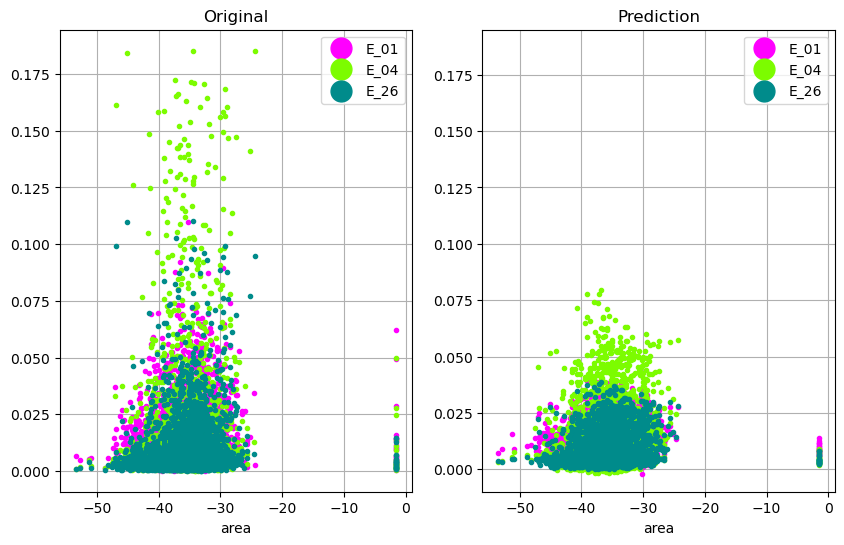

In [107]:
# Do the same for area
test_var = X_test_nozeros[:, 8]*X_std[8]+X_mean[9]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(test_var, y_test_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(test_var, y_test_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(test_var, y_test_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.legend(markerscale=5)
plt.title("Original")
plt.xlabel('area')
plt.grid()



plt.subplot(1,2,2)
plt.plot(test_var, predictions_MLP_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(test_var, predictions_MLP_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(test_var, predictions_MLP_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.grid()
plt.legend(markerscale=5)
plt.ylim(-0.01,0.195)
plt.title("Prediction")
plt.xlabel('area')

Text(0.5, 0, 'gdet1')

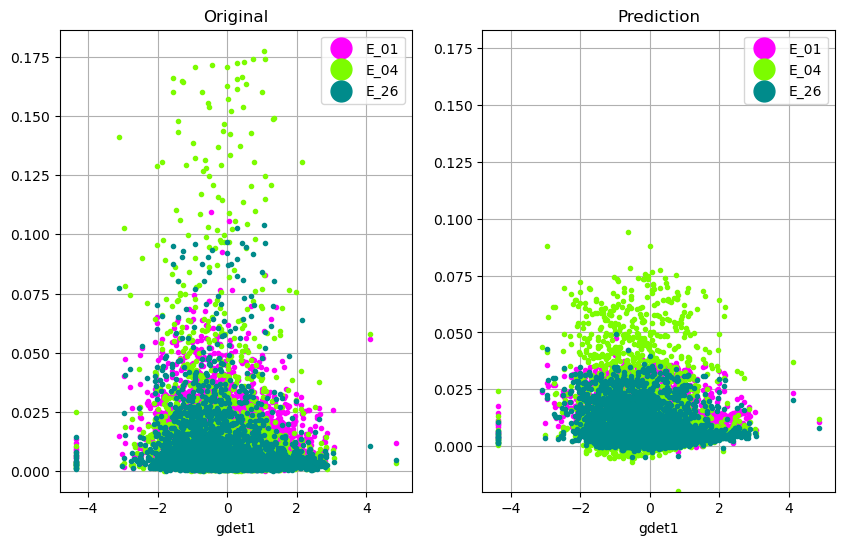

In [45]:
# Do the same for beam orientation

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(X_test_nozeros[:, 4], y_test_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 4], y_test_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 4], y_test_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.legend(markerscale=5)
plt.title("Original")
plt.xlabel('gdet1')
plt.grid()



plt.subplot(1,2,2)
plt.plot(X_test_nozeros[:, 4], predictions_MLP_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 4], predictions_MLP_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 4], predictions_MLP_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.grid()
plt.legend(markerscale=5)
plt.ylim(-0.01,0.195)
plt.title("Prediction")
plt.xlabel('gdet1')

Text(0.5, 0, 'p0x')

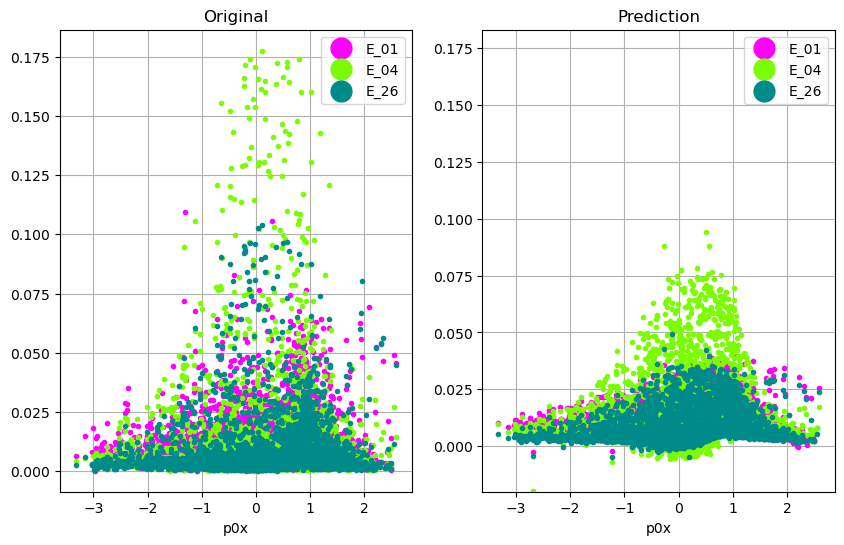

In [46]:
# And for x phase angle

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(X_test_nozeros[:, 6], y_test_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 6], y_test_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 6], y_test_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.legend(markerscale=5)
plt.title("Original")
plt.xlabel('p0x')
plt.grid()



plt.subplot(1,2,2)
plt.plot(X_test_nozeros[:, 6], predictions_MLP_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 6], predictions_MLP_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 6], predictions_MLP_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.grid()
plt.legend(markerscale=5)
plt.ylim(-0.01,0.195)
plt.title("Prediction")
plt.xlabel('p0x')

Text(0.5, 0, 'p0y')

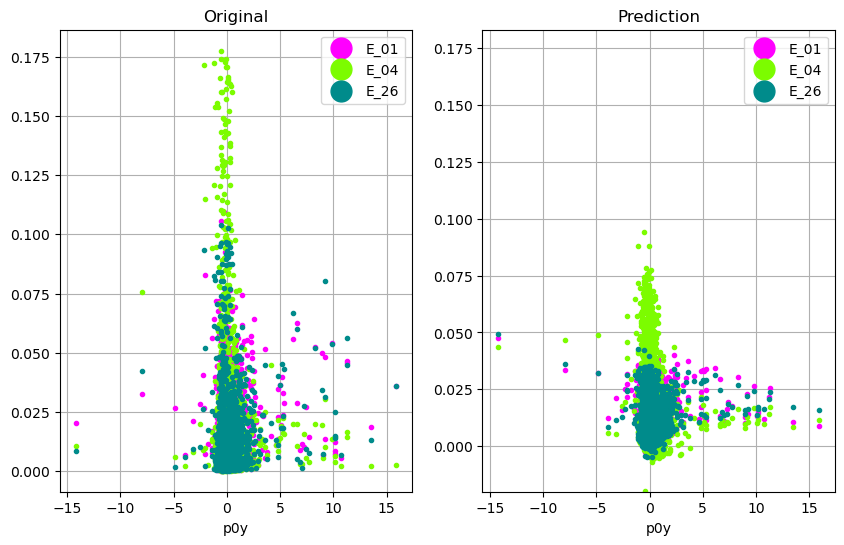

In [47]:
# and for y phase angle

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(X_test_nozeros[:, 7], y_test_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 7], y_test_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 7], y_test_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.legend(markerscale=5)
plt.title("Original")
plt.xlabel('p0y')
plt.grid()



plt.subplot(1,2,2)
plt.plot(X_test_nozeros[:, 7], predictions_MLP_nozeros[:, 1],'.', color = "magenta", label = 'E_01')
plt.plot(X_test_nozeros[:, 7], predictions_MLP_nozeros[:, 4],'.', color = "lawngreen", label = 'E_04')
plt.plot(X_test_nozeros[:, 7], predictions_MLP_nozeros[:, 20],'.', color = "darkcyan", label = 'E_26')
plt.grid()
plt.legend(markerscale=5)
plt.ylim(-0.02,0.183)
plt.title("Prediction")
plt.xlabel('p0y')